In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% ! important; }<style>"))

/var/folders/jn/wfpqyzfx0t7cprw54pg29r1h0000gn/T/ipykernel_92958/2348643420.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np 
import ezc3d
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import stats
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pickle

In [5]:
#import poi data 
poi_metrics = pd.read_csv("/Volumes/Emilio's Ex/code/Data/OpenBiomechanicsProject/openbiomechanics/baseball_pitching/data/poi/poi_metrics.csv")

poi_metrics_copy = poi_metrics.copy() 
poi_metrics_copy.head()


,session_pitch,session,p_throws,pitch_type,pitch_speed_mph,max_shoulder_internal_rotational_velo,max_elbow_extension_velo,max_torso_rotational_velo,max_rotation_hip_shoulder_separation,max_elbow_flexion,max_shoulder_external_rotation,elbow_flexion_fp,elbow_pronation_fp,rotation_hip_shoulder_separation_fp,shoulder_horizontal_abduction_fp,shoulder_abduction_fp,shoulder_external_rotation_fp,lead_knee_extension_angular_velo_fp,lead_knee_extension_angular_velo_br,lead_knee_extension_angular_velo_max,torso_anterior_tilt_fp,torso_lateral_tilt_fp,torso_rotation_fp,pelvis_anterior_tilt_fp,pelvis_lateral_tilt_fp,pelvis_rotation_fp,max_cog_velo_x,torso_rotation_min,max_pelvis_rotational_velo,glove_shoulder_horizontal_abduction_fp,glove_shoulder_abduction_fp,glove_shoulder_external_rotation_fp,glove_shoulder_abduction_mer,elbow_flexion_mer,torso_anterior_tilt_mer,torso_lateral_tilt_mer,torso_rotation_mer,elbow_varus_moment,shoulder_internal_rotation_moment,torso_anterior_tilt_br,torso_lateral_tilt_br,torso_rotation_br,lead_knee_extension_from_fp_to_br,cog_velo_pkh,stride_length,stride_angle,arm_slot,timing_peak_torso_to_peak_pelvis_rot_velo,max_shoulder_horizontal_abduction,shoulder_transfer_fp_br,shoulder_generation_fp_br,shoulder_absorption_fp_br,elbow_transfer_fp_br,elbow_generation_fp_br,elbow_absorption_fp_br,lead_hip_transfer_fp_br,lead_hip_generation_fp_br,lead_hip_absorption_fp_br,lead_knee_transfer_fp_br,lead_knee_generation_fp_br,lead_knee_absorption_fp_br,rear_hip_transfer_pkh_fp,rear_hip_generation_pkh_fp,rear_hip_absorption_pkh_fp,rear_knee_transfer_pkh_fp,rear_knee_generation_pkh_fp,rear_knee_absorption_pkh_fp,pelvis_lumbar_transfer_fp_br,thorax_distal_transfer_fp_br,rear_grf_x_max,rear_grf_y_max,rear_grf_z_max,rear_grf_mag_max,rear_grf_angle_at_max,lead_grf_x_max,lead_grf_y_max,lead_grf_z_max,lead_grf_mag_max,lead_grf_angle_at_max,peak_rfd_rear,peak_rfd_lead
0,1031_2,1031,R,FF,90.4,4533.2480,2445.8177,958.0878,32.3152,109.9971,162.3480,86.3476,13.8688,31.5769,53.7302,88.9089,12.4060,160.4524,449.4070,452.7888,-2.6113,-7.0313,0.3425,8.2744,-1.7844,31.7105,3.3113,-21.1062,609.9531,38.3919,85.9397,-46.6380,45.4970,93.9717,16.9991,22.1885,99.4708,141.1720,135.2726,34.1093,16.9053,111.1709,10.1399,0.4643,0.8374,5.3785,39.7377,0.0223,53.8175,471.6631,72.5180,8.1687,481.4378,7.0827,88.0793,48.2958,11.5949,119.5385,70.8131,74.7670,32.1040,130.8791,173.1504,37.6984,33.8403,111.5650,88.4883,157.7995,479.8318,1019.3193,103.0399,1497.9859,1736.0368,55.7071,1278.4966,270.7849,2484.8747,2782.9580,63.3501,11.6564,170.4620
1,1031_3,1031,R,FF,90.4,4571.1735,2389.5438,969.5766,32.5547,109.1065,162.8656,88.6095,12.6106,31.2877,55.7340,87.0463,18.5580,300.1992,490.8747,513.3286,-4.2198,-8.5668,3.1764,5.0692,-1.2554,33.9670,3.2385,-23.6528,639.6493,42.5471,85.2882,-47.7522,45.2598,93.6559,14.1951,23.5327,98.4928,144.5483,138.5700,33.9700,18.7871,112.8332,14.8421,0.4367,0.8316,1.1214,42.9766,0.0139,55.9667,468.4177,66.5717,9.3845,474.0084,6.4195,81.1477,65.9816,12.0415,110.9249,89.3801,67.1017,23.9261,125.1987,180.7929,40.8556,28.0193,109.6130,104.7412,170.3120,477.8022,989.5197,109.2064,1502.8258,1728.0176,60.2863,1436.1255,252.1999,2690.7521,3038.8913,62.3087,9.5715,183.6636
2,1097_1,1097,R,FF,77.6,4165.3055,2426.3029,1090.2269,33.1477,123.4752,158.8107,121.7674,30.4130,31.7880,47.1102,95.6806,5.7281,-176.7390,318.5102,333.5518,-3.6689,-4.9416,-9.6014,9.5675,-1.9345,22.1156,2.9110,-31.6853,881.1570,46.9422,81.8611,-33.7316,28.7365,83.8787,31.2288,29.1355,129.9182,132.9853,129.8250,45.1741,21.1152,142.5116,26.2749,0.2008,0.8133,7.9460,49.1484,0.0250,49.0236,307.9884,7.2968,54.3387,301.6148,7.7581,24.0842,133.6156,4.6376,106.6119,136.0782,69.9222,26.2777,56.0486,146.2910,62.6569,51.9809,28.8661,25.1778,176.2563,361.8390,681.3699,114.3219,1094.7686,1283.0751,58.3164,957.3923,245.4411,1767.4604,2010.5341,61.5594,4.4432,52.9333
3,1097_2,1097,R,FF,77.0,3832.1715,2424.0493,1105.2275,27.9286,124.6578,155.2244,124.6367,27.9551,27.9139,46.6610,94.4698,1

## Much like the arm action scores, these are going to be "trunk" related from the POI data

max_torso_rotational_velo
max_rotation_hip_shoulder_separation
rotation_hip_shoulder_separation_fp
torso_rotation_min
max_pelvis_rotational_velo
timing_peak_torso_to_peak_pelvis_rot_velo

In [33]:
# Selecting relevant features and target variable
trunk_rotation_features = poi_metrics_copy[['max_torso_rotational_velo', 'max_rotation_hip_shoulder_separation', 
                 'max_pelvis_rotational_velo', 'timing_peak_torso_to_peak_pelvis_rot_velo','rotation_hip_shoulder_separation_fp', 'torso_rotation_min']]

arm_action_target = poi_metrics_copy['pitch_speed_mph']

# Checking for missing values
missing_values = trunk_rotation_features.isnull().sum()

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(trunk_rotation_features, arm_action_target, test_size=0.2, random_state=42)

missing_values, X_train.shape, X_test.shape

(max_torso_rotational_velo                    0
 max_rotation_hip_shoulder_separation         0
 max_pelvis_rotational_velo                   0
 timing_peak_torso_to_peak_pelvis_rot_velo    0
 rotation_hip_shoulder_separation_fp          0
 torso_rotation_min                           0
 dtype: int64,
 (328, 6),
 (83, 6))

In [21]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 5,
    'eta': 0.1,
    'objective': 'reg:squarederror'
}

num_boost_round = 100
trunk_rotation = xgb.train(params, dtrain, num_boost_round)


In [22]:
y_pred_xgb = trunk_rotation.predict(dtest)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

Root Mean Squared Error: 3.288279154972407


<Figure size 1000x700 with 0 Axes>

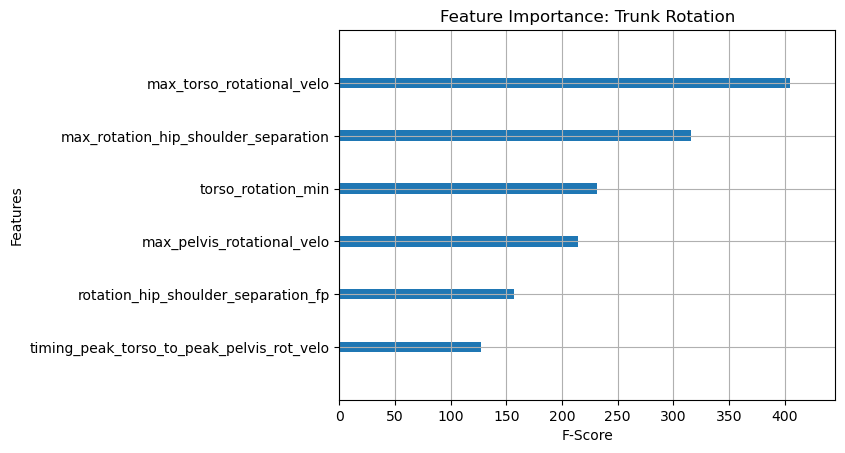

In [25]:
# Calculate and print RMSE
rmse_xgb = np.sqrt(mse_xgb)
print(f"Root Mean Squared Error: {rmse_xgb}")

# Plot Feature Importance
plt.figure(figsize=(10, 7))
xgb.plot_importance(trunk_rotation,importance_type='weight',show_values=False)
plt.title('Feature Importance: Trunk Rotation')
plt.ylabel('Features')
plt.xlabel('F-Score')
plt.show()

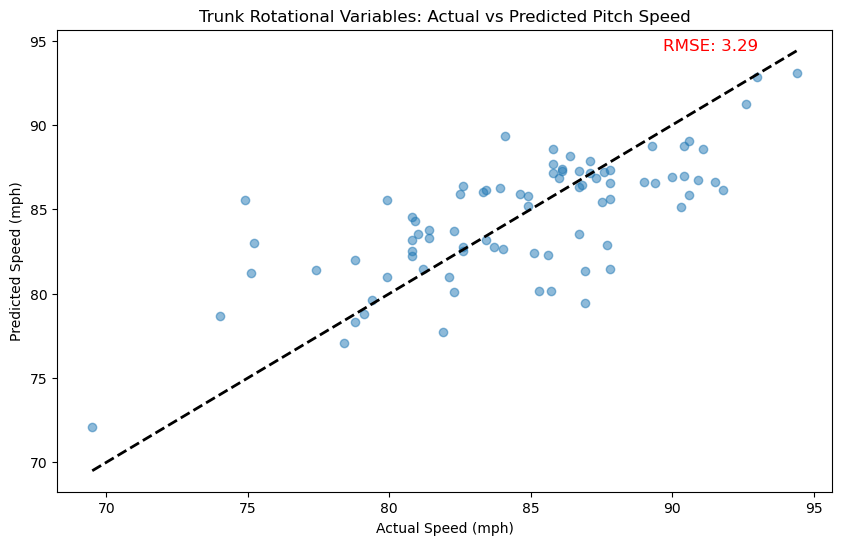

In [27]:
#visualize actual vs predicted mph

comparison_velo = pd.DataFrame({
    'Actual Speed (mph)': y_test,
    'Predicted Speed (mph)': y_pred_xgb
})

# Calculate RMSE for the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(comparison_velo['Actual Speed (mph)'], comparison_velo['Predicted Speed (mph)'], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line of perfect prediction

x_text = y_test.max() * .95  # 95% of the max value
y_text = y_test.max() * 1  # 80% of the max value

plt.text(x_text, y_text, f'RMSE: {rmse:.2f}', fontsize=12, color='red')
plt.xlabel('Actual Speed (mph)')
plt.ylabel('Predicted Speed (mph)')
plt.title('Trunk Rotational Variables: Actual vs Predicted Pitch Speed')
plt.show()


In [28]:
#save model
file_path = "/Volumes/Emilio's Ex/code/Python /OpenBiomechanics/trunk_rotation_model.pkl"  # Replace with your actual file path

# Save the model using pickle
with open(file_path, 'wb') as file:
    pickle.dump(trunk_rotation, file)

In [34]:

model_features = trunk_rotation_features.columns.tolist()


#prepare the full dataset for predictions
X_full = poi_metrics_copy[model_features]
full_data_dmatrix = xgb.DMatrix(X_full)
y_pred_xgb = trunk_rotation.predict(full_data_dmatrix)

# Get feature importances from the trained model
feature_importances = trunk_rotation.get_score(importance_type='weight')
total_importance = sum(feature_importances.values())
normalized_importances = {k: v / total_importance for k, v in feature_importances.items()}

# Function to get pitcher data by session_pitch
def get_pitcher_data_by_session(dataset, session_pitch, features):
    """
    Extracts pitcher data for a given session_pitch from the dataset.
    """
    pitcher_data = dataset[dataset['session_pitch'] == session_pitch]
    if pitcher_data.empty:
        raise ValueError(f"No data found for session_pitch '{session_pitch}'")
    return pitcher_data[features].iloc[0]

# Specify the session_pitch_id to analyze
session_pitch_id = '2843_5'  # Replace with the actual session_pitch ID

try:
    # Retrieve pitcher data for the specified session_pitch_id
    pitcher_data = get_pitcher_data_by_session(poi_metrics_copy, session_pitch_id, model_features)

    # Calculate Percentiles and Impact on Velocity
    percentiles = {variable: stats.percentileofscore(poi_metrics_copy[variable], pitcher_data[variable]) 
                   for variable in trunk_rotation_features}
    impact_on_velocity = {variable: (pitcher_data[variable] - poi_metrics_copy[variable].median()) * normalized_importances.get(variable, 0)
                          for variable in trunk_rotation_features}

    # Combine and display percentiles and impact on velocity
    percentiles_df = pd.DataFrame(list(percentiles.items()), columns=['Feature', 'Percentile'])
    impact_on_velocity_df = pd.DataFrame(list(impact_on_velocity.items()), columns=['Feature', 'Impact on Velocity'])
    combined_df = pd.merge(percentiles_df, impact_on_velocity_df, on='Feature')
    print("Pitcher Analysis for session_pitch:", session_pitch_id)
    print(combined_df)

    # Find actual vs predicted velocity
    actual_velocity = poi_metrics_copy[poi_metrics_copy['session_pitch'] == session_pitch_id]['pitch_speed_mph'].iloc[0]
    predicted_velocity = y_pred_xgb[poi_metrics_copy.index[poi_metrics_copy['session_pitch'] == session_pitch_id][0]]
    print("\nActual Pitch Speed (mph):", actual_velocity.round(2))
    print("Predicted Pitch Speed (mph):", predicted_velocity.round(2))

except ValueError as e:
    print(e)


Pitcher Analysis for session_pitch: 2843_5
                                     Feature  Percentile  Impact on Velocity
0                  max_torso_rotational_velo    9.002433          -27.776576
1       max_rotation_hip_shoulder_separation   93.917275            2.143177
2                 max_pelvis_rotational_velo    7.542579          -16.940683
3  timing_peak_torso_to_peak_pelvis_rot_velo   77.007299            0.000736
4        rotation_hip_shoulder_separation_fp   91.240876            0.948843
5                         torso_rotation_min   50.364964            0.009941

Actual Pitch Speed (mph): 86.2
Predicted Pitch Speed (mph): 85.97
